# Confirm Novel Distance Metric Corrects for Variance

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
from scipy.spatial.distance import cdist
import tqdm

from biovectors_modules.word2vec_analysis_helper import window
from biovectors_modules.plot_helper import overlay_token_with_model

# Grab Average Distance for Single Model

In [2]:
year_models = sorted(
    list(Path("output/aligned_models").glob("*model/*_0_fulltext_aligned.kv")),
    key=lambda x: int(x.stem.split("_")[0]),
)

In [3]:
common_vocab = set()
for model in tqdm.tqdm(reversed(year_models)):
    word_model = KeyedVectors.load(str(model))
    if len(common_vocab) == 0:
        common_vocab = set(word_model.vocab.keys())
    else:
        common_vocab &= set(word_model.vocab.keys())

22it [02:51,  7.79s/it]


In [4]:
combined_model_data_rows = []
for model_one, model_two in window(year_models, 2):
    model_one_prefix = model_one.stem.split("_")[0]
    model_two_prefix = model_two.stem.split("_")[0]

    word2vec_model_one = KeyedVectors.load(str(model_one))
    word2vec_model_two = KeyedVectors.load(str(model_two))

    for tok in tqdm.tqdm(common_vocab):
        cosine_dist_values = cdist(
            [word2vec_model_one[tok]], [word2vec_model_two[tok]], "cosine"
        )
        combined_model_data_rows.append(
            {
                "tok": tok,
                "distance": cosine_dist_values[0][0],
                "year_1": model_one_prefix,
                "year_2": model_two_prefix,
            }
        )

single_model_df = pd.DataFrame.from_records(combined_model_data_rows)
print(single_model_df.shape)
single_model_df

100%|██████████| 95403/95403 [00:02<00:00, 44856.55it/s]


(2003463, 4)


,tok,distance,year_1,year_2
0,,0.032921,2000,2001
1,gip,0.760982,2000,2001
2,g(t,0.633403,2000,2001
3,snugly,0.702754,2000,2001
4,species_6938,0.620665,2000,2001
...,...,...,...,...
2003458,evaluator,0.087213,2020,2021
2003459,cellline_cvcl_0063,0.035669,2020,2021
2003460,pronuclear,0.167835,2020,2021
2003461,disease_mesh_d005266,0.114423,2020,2021


In [5]:
single_distance_df = (
    single_model_df
    >> ply_tdy.unite("timepoint", "year_1", "year_2", sep="-")
    >> ply.group_by("timepoint")
    >> ply.define(distance="mean(distance)")
    >> ply.ungroup()
    >> ply.select("timepoint", "distance")
    >> ply.distinct()
    >> ply.arrange("timepoint")
)

middle_estimate_2010 = single_distance_df.iloc[10].values[1]
middle_estimate_2015 = single_distance_df.iloc[15].values[1]

single_distance_df = single_distance_df >> ply.define(
    pct_diff_2010="abs(distance/middle_estimate_2010 - 1)",
    pct_diff_2015="abs(distance/middle_estimate_2015 - 1)",
)
single_distance_df

,timepoint,distance,pct_diff_2010,pct_diff_2015
0,2000-2001,0.460188,0.521080,0.851998
95403,2001-2002,0.454005,0.500641,0.827112
190806,2002-2003,0.447297,0.478469,0.800116
286209,2003-2004,0.437733,0.446856,0.761625
381612,2004-2005,0.425363,0.405969,0.711844
477015,2005-2006,0.412138,0.362257,0.658621
572418,2006-2007,0.400395,0.323441,0.611361
667821,2007-2008,0.383397,0.267257,0.542953
763224,2008-2009,0.341803,0.129777,0.375565
858627,2009-2010,0.311718,0.030335,0.254489


# Grab Average Distance for Multi Models

In [6]:
multi_model_distances = sorted(
    list(Path("output/final_distances/pubtator").glob("*tsv")),
    key=lambda x: int(x.stem.split("_")[1].split("-")[0]),
)

multi_model_df_list = []
for multi_distance_path in tqdm.tqdm(multi_model_distances):
    years_compared = multi_distance_path.stem.split("_")[1].split("-")
    temp_multi_model_df = (
        pd.read_csv(multi_distance_path, sep="\t")
        >> ply.define(
            intra_distance=f"averaged_{years_compared[0]}_distance+averaged_{years_compared[1]}_distance"
        )
        >> ply.rename(
            distance="adjusted_distance",
            timepoint="year_pair",
            inter_distance="averaged_inter_distance",
        )
        >> ply.select(
            "tok", "distance", "timepoint", "inter_distance", "intra_distance"
        )
    )
    multi_model_df_list.append(temp_multi_model_df)
multi_model_df = pd.concat(multi_model_df_list, axis=0)
multi_model_df

100%|██████████| 21/21 [00:11<00:00,  1.88it/s]


,tok,distance,timepoint,inter_distance,intra_distance
0,NaN,0.672220,2000-2001,0.034780,0.051739
1,bunion,1.008433,2000-2001,0.562070,0.557369
2,8-,0.934400,2000-2001,0.267506,0.286287
3,pmfs,1.250427,2000-2001,0.787887,0.630095
4,sch,1.097366,2000-2001,0.333683,0.304076
...,...,...,...,...,...
943254,gpse,1.667414,2020-2021,0.988439,0.592798
943255,atcase,2.562479,2020-2021,0.589875,0.230197
943256,deltaggamma,1.124444,2020-2021,0.806117,0.716903
943257,disease_mesh_c563032,0.654406,2020-2021,0.110094,0.168235


In [7]:
multi_distance_df = (
    multi_model_df
    >> ply.query(f"tok in {list(common_vocab)}")
    >> ply.group_by("timepoint")
    >> ply.define(distance="mean(distance)")
    >> ply.ungroup()
    >> ply.select("timepoint", "distance")
    >> ply.distinct()
    >> ply.arrange("timepoint")
)
middle_estimate_2010 = multi_distance_df.iloc[10].values[1]
middle_estimate_2015 = multi_distance_df.iloc[15].values[1]
multi_distance_df = multi_distance_df >> ply.define(
    pct_diff_2015="abs(distance/middle_estimate_2015 - 1)",
    pct_diff_2010="abs(distance/middle_estimate_2010 - 1)",
)
multi_distance_df

,timepoint,distance,pct_diff_2015,pct_diff_2010
1,2000-2001,1.070159,0.038589,0.075159
1,2001-2002,1.069658,0.039039,0.075592
1,2002-2003,1.065960,0.042361,0.078788
1,2003-2004,1.064783,0.043418,0.079805
1,2004-2005,1.070446,0.038331,0.074911
1,2005-2006,1.071332,0.037535,0.074145
1,2006-2007,1.078699,0.030917,0.067779
1,2007-2008,1.124210,0.009969,0.028448
1,2008-2009,1.122465,0.008401,0.029956
1,2009-2010,1.103113,0.008983,0.046680


In [8]:
output_file_folder = Path("output/figure_data_and_figures/novel_distance_visualization")

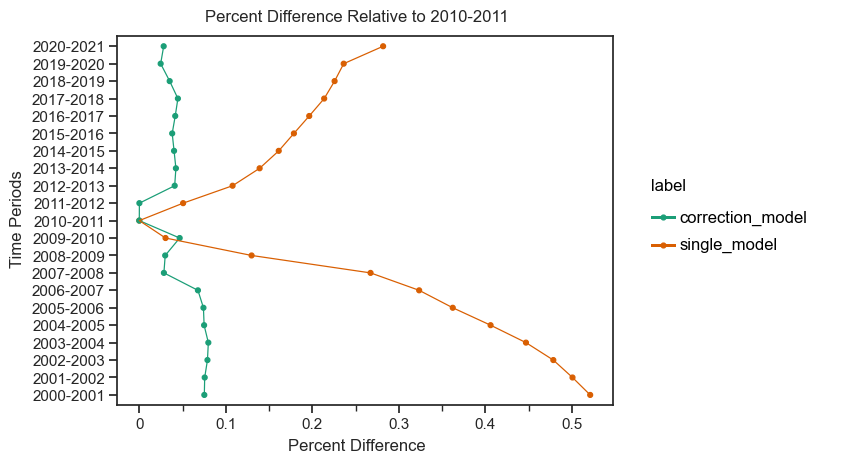

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/novel_distance_visualization/percent_difference_2010-2011_plot.svg
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/novel_distance_visualization/percent_difference_2010-2011_plot.png


In [9]:
g = (
    single_distance_df
    >> ply.define(label='"single_model"')
    >> ply.call(".append", multi_distance_df >> ply.define(label='"correction_model"'))
    >> (
        p9.ggplot()
        + p9.aes(x="timepoint", y="pct_diff_2010", color="label", group="label")
        + p9.geom_point()
        + p9.geom_line()
        + p9.coord_flip()
        + p9.theme_seaborn(style="white")
        + p9.labs(
            title="Percent Difference Relative to 2010-2011",
            x="Time Periods",
            y="Percent Difference",
        )
        + p9.scale_color_brewer("qual", palette="Dark2")
    )
)
print(g)
g.save(f"{str(output_file_folder)}/percent_difference_2010-2011_plot.svg")
g.save(f"{str(output_file_folder)}/percent_difference_2010-2011_plot.png", dpi=300)

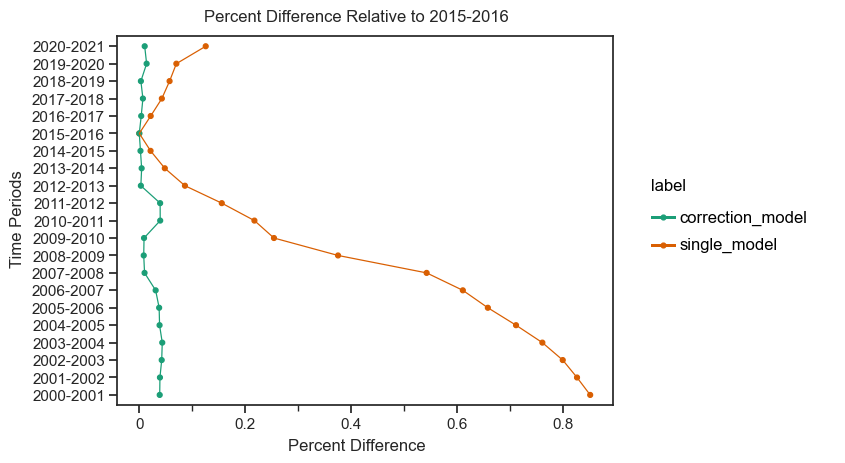

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/novel_distance_visualization/percent_difference_2015-2016_plot.svg
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/novel_distance_visualization/percent_difference_2015-2016_plot.png


In [10]:
g = (
    single_distance_df
    >> ply.define(label='"single_model"')
    >> ply.call(".append", multi_distance_df >> ply.define(label='"correction_model"'))
    >> (
        p9.ggplot()
        + p9.aes(x="timepoint", y="pct_diff_2015", color="label", group="label")
        + p9.geom_point()
        + p9.geom_line()
        + p9.coord_flip()
        + p9.theme_seaborn(style="white")
        + p9.labs(
            title="Percent Difference Relative to 2015-2016",
            x="Time Periods",
            y="Percent Difference",
        )
        + p9.scale_color_brewer("qual", palette="Dark2")
    )
)
print(g)
g.save(f"{str(output_file_folder)}/percent_difference_2015-2016_plot.svg")
g.save(f"{str(output_file_folder)}/percent_difference_2015-2016_plot.png", dpi=300)

In [11]:
(
    single_distance_df
    >> ply.define(label='"single_model"')
    >> ply.call(".append", multi_distance_df >> ply.define(label='"correction_model"'))
    >> ply.call(
        ".to_csv",
        f"{str(output_file_folder)}/correction_metric_data.tsv",
        sep="\t",
        index=False,
    )
)

# Plot known changepoint examples.

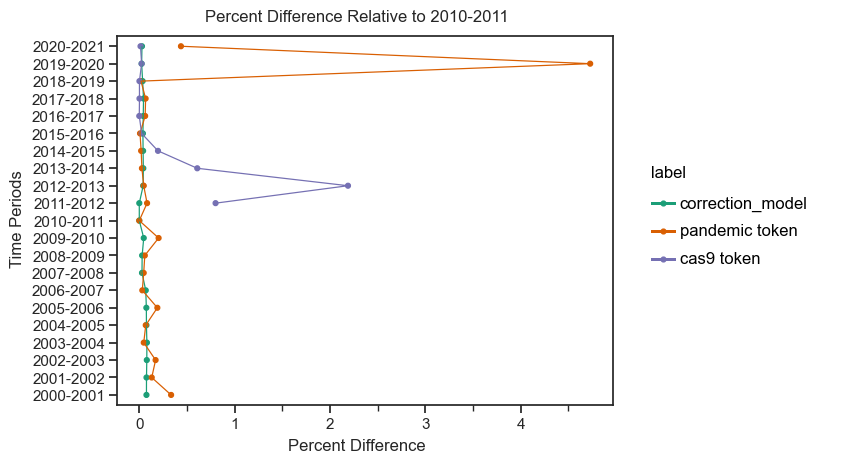

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/novel_distance_visualization/pandemic_cas9_changepoint_example_plot.svg
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figure_data_and_figures/novel_distance_visualization/pandemic_cas9_changepoint_example_plot.png


In [33]:
tok = ["pandemic", "cas9"]
g = overlay_token_with_model(tok, multi_model_df, multi_distance_df)
print(g)
g.save(f'{str(output_file_folder)}/{"_".join(tok)}_changepoint_example_plot.svg')
g.save(
    f'{str(output_file_folder)}/{"_".join(tok)}_changepoint_example_plot.png', dpi=300
)